### Introduction
Understanding human personality is a complex yet valuable endeavor in fields ranging from psychology to marketing and human resources. This practical assignment aims to explore personality profiling through the application of unsupervised clustering algorithms on the "Big Five Personality Test" dataset. The Big Five model classifies personality traits into five broad dimensions: Openness, Conscientiousness, Extraversion, Agreeableness, and Neuroticism. Each individual in the dataset has responded to multiple questions that reflect these traits, with scores ranging from 1 to 5.

The main objective of this assignment is to identify meaningful personality groupings by analyzing patterns in these trait scores. Through a combination of data preprocessing, dimensionality reduction, and implementation of clustering algorithms such as K-Means, Hierarchical Clustering, and DBSCAN, we aim to uncover hidden structures within the dataset. The performance of each model will be evaluated using internal validation metrics like the Silhouette Score and the Davies-Bouldin Index. In addition, visualizations will be employed to interpret the resulting clusters and gain insights into the diversity of human personalities represented in the data.

### Importing libraries

In [32]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
import random

In [33]:
random.seed(42)
np.random.seed(42)

### Load the dataset

In [2]:
df = pd.read_csv('data/data-final.csv', delimiter='\t')

In [3]:
df.shape

(1015341, 110)

In [4]:
df.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,2016-03-03 02:01:01,768.0,1024.0,9.0,234.0,6,1,GB,51.5448,0.1991
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,...,2016-03-03 02:01:20,1360.0,768.0,12.0,179.0,11,1,MY,3.1698,101.706
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,2016-03-03 02:01:56,1366.0,768.0,3.0,186.0,7,1,GB,54.9119,-1.3833
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,2016-03-03 02:02:02,1920.0,1200.0,186.0,219.0,7,1,GB,51.75,-1.25
4,3.0,3.0,3.0,3.0,5.0,3.0,3.0,5.0,3.0,4.0,...,2016-03-03 02:02:57,1366.0,768.0,8.0,315.0,17,2,KE,1.0,38.0


## Data Cleaning

### Checking for missing values

In [5]:
df.isnull().sum()

EXT1                     1783
EXT2                     1783
EXT3                     1783
EXT4                     1783
EXT5                     1783
                         ... 
endelapse                   0
IPC                         0
country                    77
lat_appx_lots_of_err        0
long_appx_lots_of_err       0
Length: 110, dtype: int64

In [6]:
df.isnull().values.sum()

186358

In [7]:
df.dropna(inplace=True)

The dataset was filtered to retain only the columns related to the Big Five personality traits, identified by standard prefixes (EXT, EST, AGR, CSN, OPN). To enhance readability, each column was then renamed using descriptive question texts that reflect the psychological meaning behind the trait it measures. This resulted in a clean, focused dataset suitable for clustering and interpretation.

In [8]:
trait_cols = [col for col in df.columns if re.match(r'^(EXT|EST|AGR|CSN|OPN)\d+$', col)]
df = df[trait_cols]

In [9]:
df.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,5.0,1.0,4.0,1.0,4.0,1.0,5.0,3.0,4.0,5.0
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,...,1.0,2.0,4.0,2.0,3.0,1.0,4.0,2.0,5.0,3.0
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,5.0,1.0,2.0,1.0,4.0,2.0,5.0,3.0,4.0,4.0
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,4.0,2.0,5.0,2.0,3.0,1.0,4.0,4.0,3.0,3.0
4,3.0,3.0,3.0,3.0,5.0,3.0,3.0,5.0,3.0,4.0,...,5.0,1.0,5.0,1.0,5.0,1.0,5.0,3.0,5.0,5.0


In [10]:
ext_questions = {'EXT1' : 'I am the life of the party',
                 'EXT2' : 'I dont talk a lot',
                 'EXT3' : 'I feel comfortable around people',
                 'EXT4' : 'I keep in the background',
                 'EXT5' : 'I start conversations',
                 'EXT6' : 'I have little to say',
                 'EXT7' : 'I talk to a lot of different people at parties',
                 'EXT8' : 'I dont like to draw attention to myself',
                 'EXT9' : 'I dont mind being the center of attention',
                 'EXT10': 'I am quiet around strangers'}

est_questions = {'EST1' : 'I get stressed out easily',
                 'EST2' : 'I am relaxed most of the time',
                 'EST3' : 'I worry about things',
                 'EST4' : 'I seldom feel blue',
                 'EST5' : 'I am easily disturbed',
                 'EST6' : 'I get upset easily',
                 'EST7' : 'I change my mood a lot',
                 'EST8' : 'I have frequent mood swings',
                 'EST9' : 'I get irritated easily',
                 'EST10': 'I often feel blue'}

agr_questions = {'AGR1' : 'I feel little concern for others',
                 'AGR2' : 'I am interested in people',
                 'AGR3' : 'I insult people',
                 'AGR4' : 'I sympathize with others feelings',
                 'AGR5' : 'I am not interested in other peoples problems',
                 'AGR6' : 'I have a soft heart',
                 'AGR7' : 'I am not really interested in others',
                 'AGR8' : 'I take time out for others',
                 'AGR9' : 'I feel others emotions',
                 'AGR10': 'I make people feel at ease'}

csn_questions = {'CSN1' : 'I am always prepared',
                 'CSN2' : 'I leave my belongings around',
                 'CSN3' : 'I pay attention to details',
                 'CSN4' : 'I make a mess of things',
                 'CSN5' : 'I get chores done right away',
                 'CSN6' : 'I often forget to put things back in their proper place',
                 'CSN7' : 'I like order',
                 'CSN8' : 'I shirk my duties',
                 'CSN9' : 'I follow a schedule',
                 'CSN10' : 'I am exacting in my work'}

opn_questions = {'OPN1' : 'I have a rich vocabulary',
                 'OPN2' : 'I have difficulty understanding abstract ideas',
                 'OPN3' : 'I have a vivid imagination',
                 'OPN4' : 'I am not interested in abstract ideas',
                 'OPN5' : 'I have excellent ideas',
                 'OPN6' : 'I do not have a good imagination',
                 'OPN7' : 'I am quick to understand things',
                 'OPN8' : 'I use difficult words',
                 'OPN9' : 'I spend time reflecting on things',
                 'OPN10': 'I am full of ideas'}


In [11]:
all_questions = {}
all_questions.update(ext_questions)
all_questions.update(est_questions)
all_questions.update(agr_questions)
all_questions.update(csn_questions)
all_questions.update(opn_questions)

In [12]:
df = df.rename(columns=all_questions)

print(df.columns.tolist())

['I am the life of the party', 'I dont talk a lot', 'I feel comfortable around people', 'I keep in the background', 'I start conversations', 'I have little to say', 'I talk to a lot of different people at parties', 'I dont like to draw attention to myself', 'I dont mind being the center of attention', 'I am quiet around strangers', 'I get stressed out easily', 'I am relaxed most of the time', 'I worry about things', 'I seldom feel blue', 'I am easily disturbed', 'I get upset easily', 'I change my mood a lot', 'I have frequent mood swings', 'I get irritated easily', 'I often feel blue', 'I feel little concern for others', 'I am interested in people', 'I insult people', 'I sympathize with others feelings', 'I am not interested in other peoples problems', 'I have a soft heart', 'I am not really interested in others', 'I take time out for others', 'I feel others emotions', 'I make people feel at ease', 'I am always prepared', 'I leave my belongings around', 'I pay attention to details', 'I

### Exploratory Data Analysis (EDA)
Exploratory Data Analysis (EDA) is a crucial step in understanding the structure and characteristics of the dataset before applying any modeling techniques. It helps uncover patterns, detect anomalies, and assess the distribution and relationships between variables.

In our analysis, we visualized the distributions of the first six personality trait features using histograms to observe their spread and skewness. A custom color palette was applied to improve readability. We also generated summary statistics to examine the central tendencies and variability within each trait.

To further explore relationships among traits, we created a correlation heatmap, which highlighted the strength and direction of associations between different personality dimensions. These insights guide feature selection, scaling decisions, and help anticipate clustering behavior.

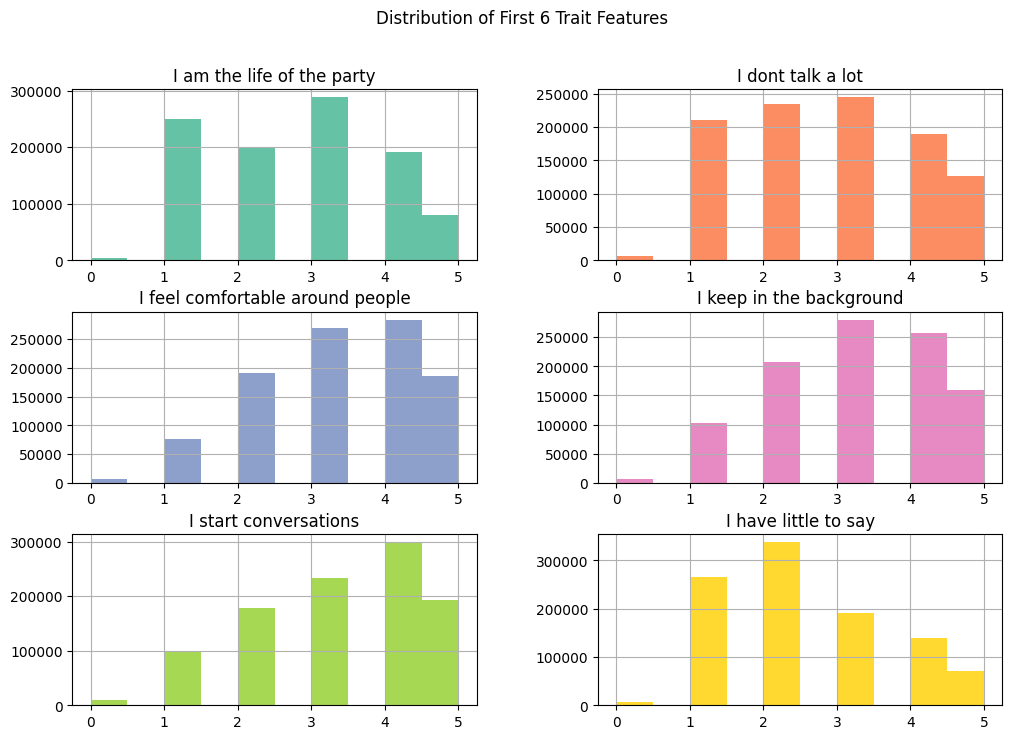

In [13]:
palette = sns.color_palette("Set2", n_colors=6)

axes = df.iloc[:, :6].hist(bins=10, figsize=(12, 8))
for ax, color in zip(axes.flatten(), palette):
    for patch in ax.patches:
        patch.set_facecolor(color)

plt.suptitle("Distribution of First 6 Trait Features")
plt.show()


In [14]:
df.describe()

,I am the life of the party,I dont talk a lot,I feel comfortable around people,I keep in the background,I start conversations,I have little to say,I talk to a lot of different people at parties,I dont like to draw attention to myself,I dont mind being the center of attention,I am quiet around strangers,...,I have a rich vocabulary,I have difficulty understanding abstract ideas,I have a vivid imagination,I am not interested in abstract ideas,I have excellent ideas,I do not have a good imagination,I am quick to understand things,I use difficult words,I spend time reflecting on things,I am full of ideas
count,1.012050e+06,1.012050e+06,1.012050e+06,1.012050e+06,1.012050e+06,1.012050e+06,1.012050e+06,1.012050e+06,1.012050e+06,1.012050e+06,...,1.012050e+06,1.012050e+06,1.012050e+06,1.012050e+06,1.012050e+06,1.012050e+06,1.012050e+06,1.012050e+06,1.012050e+06,1.012050e+06
mean,2.647892e+00,2.773242e+00,3.288202e+00,3.140699e+00,3.276805e+00,2.401119e+00,2.771527e+00,3.414799e+00,2.963761e+00,3.556569e+00,...,3.654832e+00,2.075704e+00,4.000128e+00,1.999646e+00,3.793071e+00,1.894524e+00,3.976501e+00,3.182712e+00,4.123180e+00,3.958640e+00
std,1.264476e+00,1.323982e+00,1.215083e+00,1.237473e+00,1.277636e+00,1.225812e+00,1.400348e+00,1.271954e+00,1.346053e+00,1.305249e+00,...,1.157125e+00,1.112574e+00,1.097177e+00,1.090222e+00,9.924004e-01,1.104077e+00,1.008545e+00,1.255386e+00,1.041208e+00,1.034486e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,...,3.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,3.000000e+00,2.000000e+00,4.000000e+00,3.000000e+00
50%,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,...,4.000000e+00,2.000000e+00,4.000000e+00,2.000000e+00,4.000000e+00,2.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00
75%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00,...,5.000000e+00,3.000000e+00,5.000000e+00,3.000000e+00,5.000000e+00,2.000000e+00,5.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


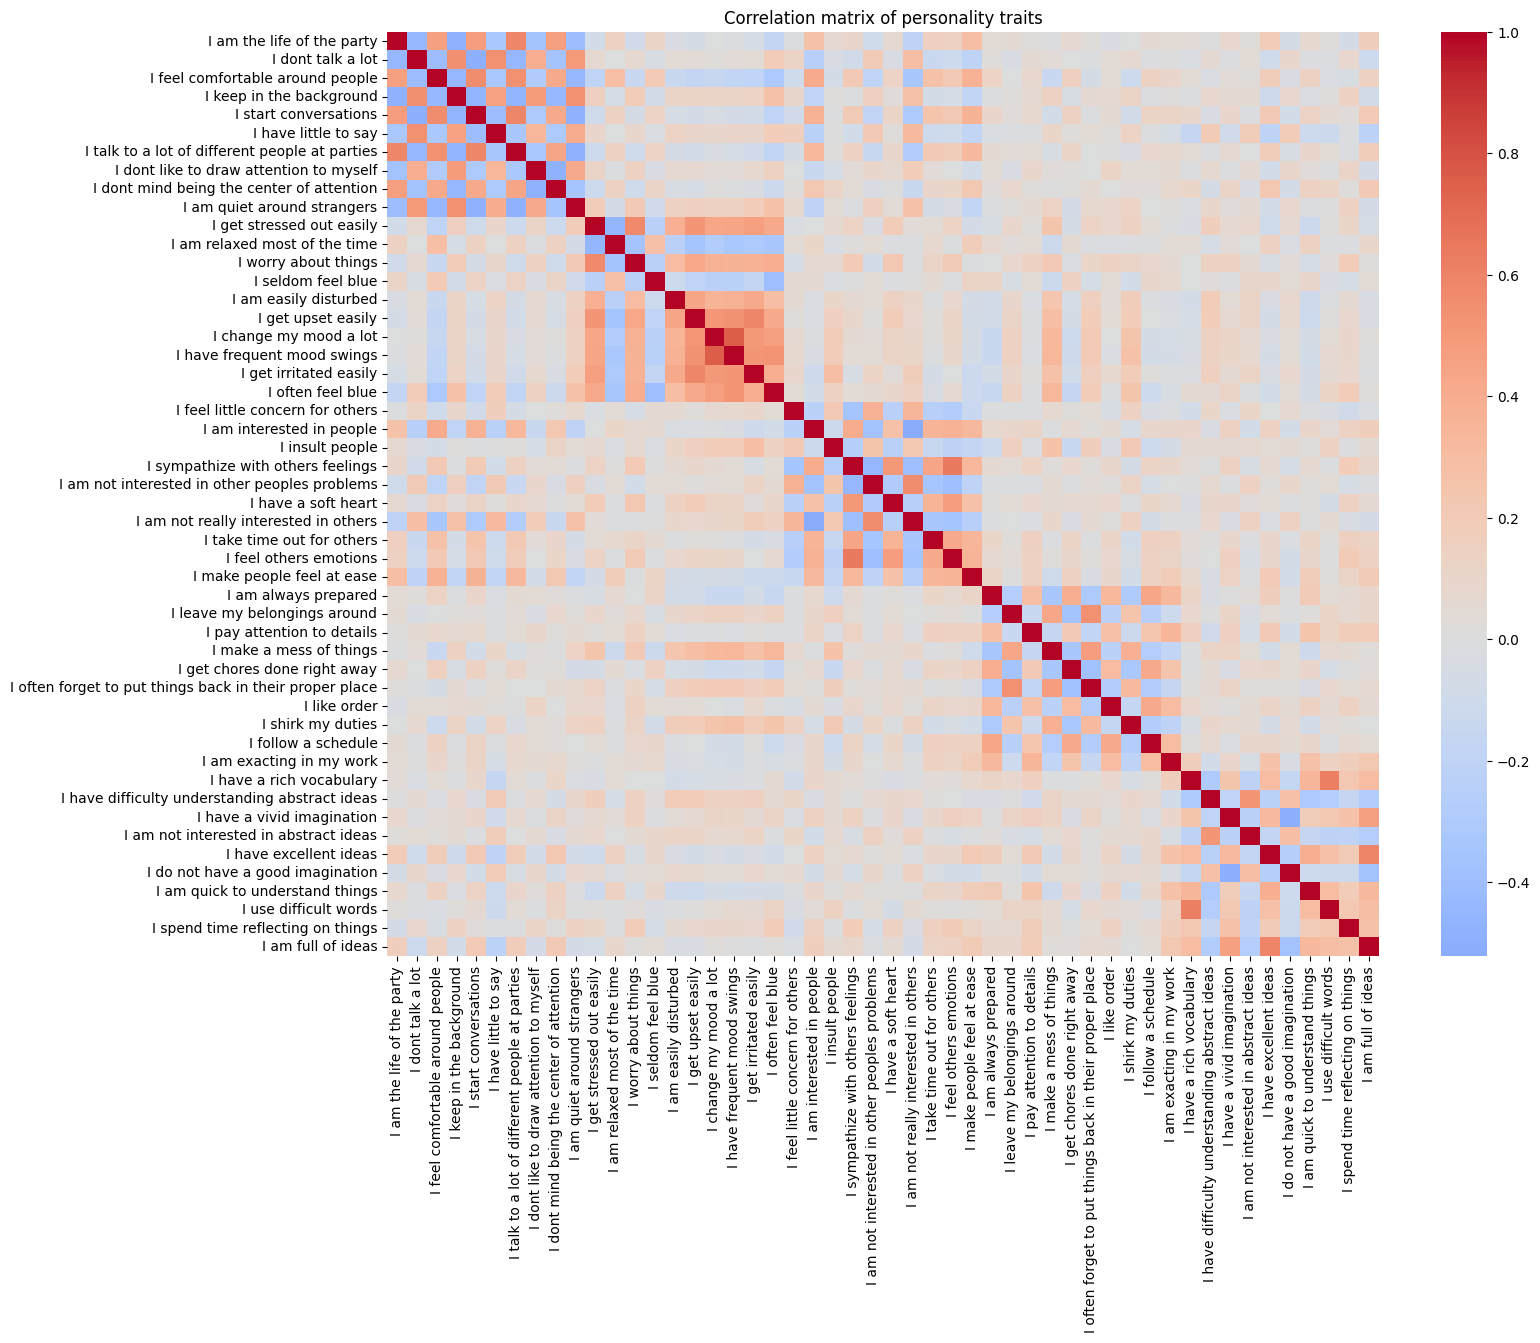

In [ ]:
plt.figure(figsize=(16,12))
corr = df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation matrix of personality traits')
plt.show()

### Feature Scaling and Sampling
Before applying clustering algorithms, it is essential to scale the data, especially when using distance-based methods like K-Means and DBSCAN. We used StandardScaler to standardize the personality trait features so that each has a mean of 0 and a standard deviation of 1. This ensures that all features contribute equally to the clustering process, preventing traits with larger value ranges from dominating the distance calculations.

Due to computational limitations of the local machine’s CPU, I could not process the entire dataset efficiently. After discussion and approval from the TA team, I sampled 7.5% of the standardized dataset to make the clustering models computationally feasible while still preserving a representative portion of the data. This random sampling was done with a fixed seed to ensure reproducibility.

In [16]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

print(df_scaled.head())

   I am the life of the party  I dont talk a lot  \
0                    1.069304          -1.339326   
1                    0.278462           1.681865   
2                   -0.512380           0.171269   
3                   -0.512380          -0.584028   
4                    0.278462           0.171269   

   I feel comfortable around people  I keep in the background  \
0                          1.408792                 -0.921798   
1                         -0.237187                  0.694401   
2                          0.585802                  0.694401   
3                         -1.060177                 -0.113698   
4                         -0.237187                 -0.113698   

   I start conversations  I have little to say  \
0               1.348737             -1.143013   
1              -0.216655              0.488559   
2              -0.216655             -0.327227   
3               0.566041             -0.327227   
4               1.348737              0.488559

In [17]:
df_sampled = df_scaled.sample(frac=0.075, random_state=42).reset_index(drop=True)

print(f"Sampled data shape: {df_sampled.shape}")
print(df_sampled.head())

Sampled data shape: (75904, 50)
   I am the life of the party  I dont talk a lot  \
0                   -0.512380           1.681865   
1                    0.278462           0.171269   
2                    0.278462           0.926567   
3                    1.860145          -0.584028   
4                    0.278462           0.926567   

   I feel comfortable around people  I keep in the background  \
0                         -1.060177                  1.502500   
1                          0.585802                  0.694401   
2                         -1.060177                 -0.113698   
3                          0.585802                  0.694401   
4                         -1.060177                  0.694401   

   I start conversations  I have little to say  \
0              -0.999350              0.488559   
1               1.348737             -1.143013   
2              -0.216655              1.304346   
3               0.566041             -0.327227   
4             

### Dimensionality Reduction
To better understand the structure of the data and visualize potential clusters, we applied two dimensionality reduction techniques: Principal Component Analysis (PCA) and t-distributed Stochastic Neighbor Embedding (t-SNE). These methods help project high-dimensional data into two dimensions for visualization while preserving important patterns.

PCA was first used to transform the sampled dataset into two principal components. This linear technique allowed us to examine the global variance structure of the data and evaluate how much information is retained. The explained variance ratio confirmed that the two components capture a meaningful portion of the original variability.

We then applied t-SNE, a non-linear technique well-suited for visualizing complex, high-dimensional relationships. The resulting 2D scatter plots offered visual insights into how individuals might naturally group based on their personality traits, guiding our expectations for the clustering phase.

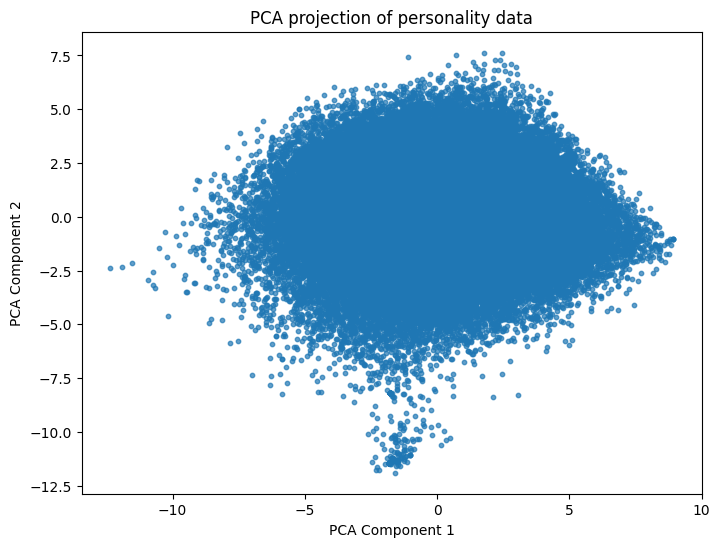

Explained variance ratio by PCA components: [0.14426886 0.10065991]


In [18]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(df_sampled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=10, alpha=0.7)
plt.title('PCA projection of personality data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

print(f'Explained variance ratio by PCA components: {pca.explained_variance_ratio_}')

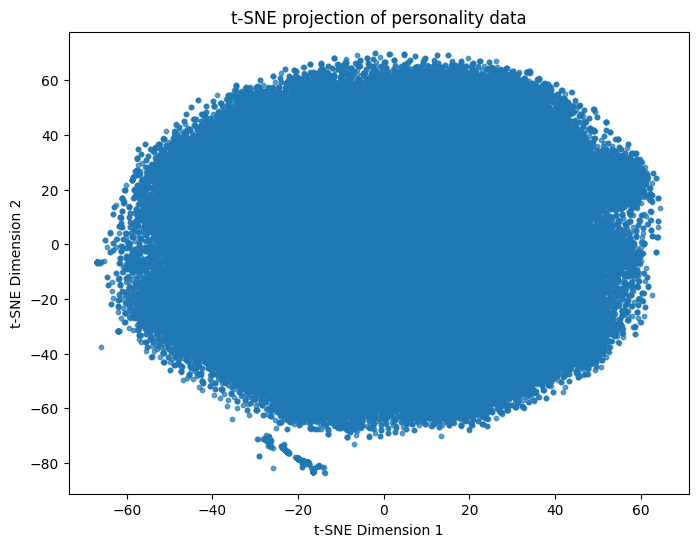

In [19]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)  
X_tsne = tsne.fit_transform(df_sampled)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], s=10, alpha=0.7)
plt.title('t-SNE projection of personality data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

### Optimal Number of Clusters
To determine the most appropriate number of clusters for our personality data, we evaluated K-Means clustering performance across a range of cluster counts (from 2 to 7) using three key internal validation metrics: Silhouette Score, Davies-Bouldin Index, and Inertia.

The Silhouette Score measures how well data points fit within their assigned clusters, with higher values indicating better-defined clusters. The Davies-Bouldin Index reflects the average similarity between clusters, where lower values are preferred. Inertia, used in the Elbow Method, assesses how tightly data points are grouped around cluster centers.

Based on the trends observed in the plots, we identified 5 clusters as the optimal choice. At this point, the Silhouette Score was relatively high, the Davies-Bouldin Index was low, and the Inertia showed a noticeable bend (or “elbow”), suggesting a balance between compactness and separation of clusters. This guided our decision to proceed with 5-group clustering in the following algorithms.

In [20]:
silhouette_scores = []
db_scores = []
inertias = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_pca)  
    silhouette_scores.append(silhouette_score(X_pca, labels))
    db_scores.append(davies_bouldin_score(X_pca, labels))
    inertias.append(kmeans.inertia_)

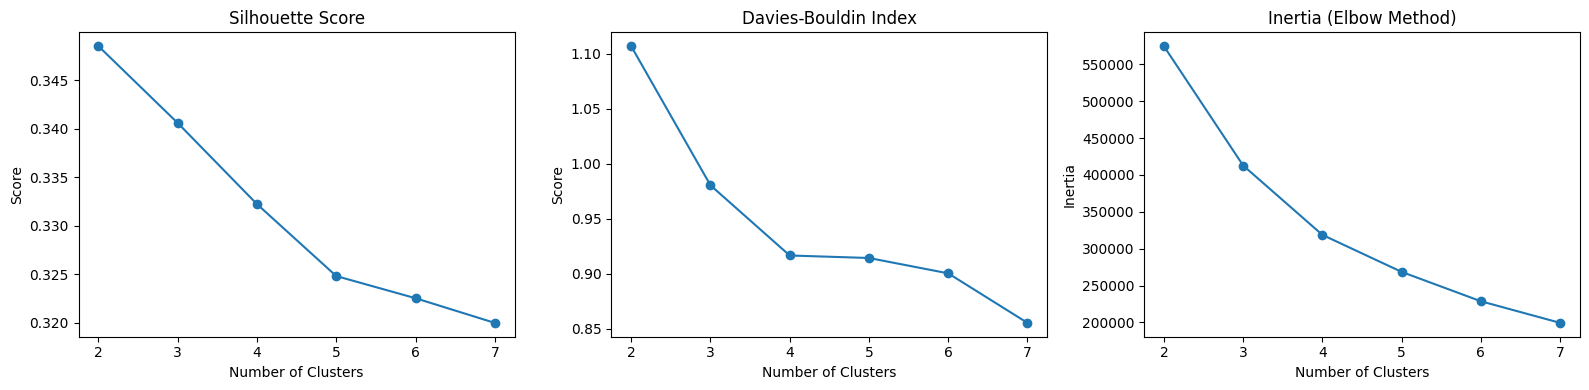

In [21]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(1, 3, 2)
plt.plot(k_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(1, 3, 3)
plt.plot(k_range, inertias, marker='o')
plt.title('Inertia (Elbow Method)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.tight_layout()
plt.show()

I defined a reusable function to visualize clustering results on the 2D PCA projection, coloring points by their assigned cluster labels.

In [22]:
def plot_clusters(X, labels, title):
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10, alpha=0.7)
    plt.colorbar(scatter, label='Cluster Label')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

### Methods
I applied three clustering algorithms—K-Means, Hierarchical Clustering, and DBSCAN—on the PCA-reduced dataset to identify personality profiles.

For K-Means, I set the number of clusters to 5 based on prior analysis. The algorithm was run with a fixed random seed for reproducibility, and its performance was evaluated using the Silhouette Score (0.3248) and Davies-Bouldin Index (0.9144). The resulting clusters were visualized on the 2D PCA projection.

Silhouette Score (KMeans): 0.3248
Davies-Bouldin Index (KMeans): 0.9144


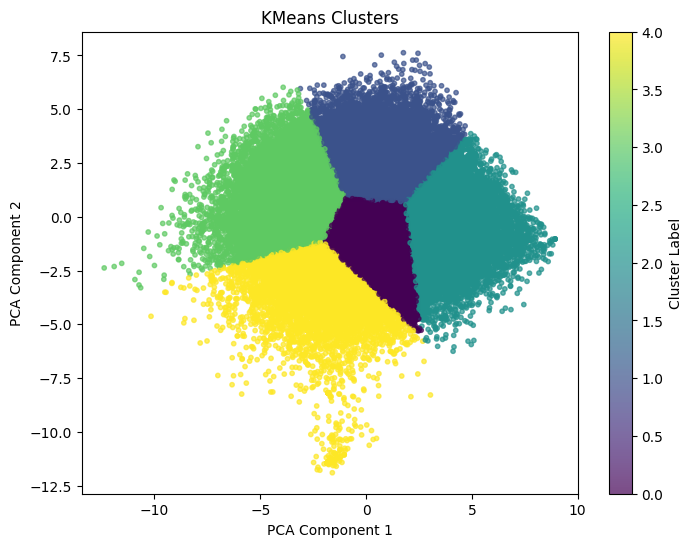

In [34]:
k = 5

kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_pca)

print(f'Silhouette Score (KMeans): {silhouette_score(X_pca, kmeans_labels):.4f}')
print(f'Davies-Bouldin Index (KMeans): {davies_bouldin_score(X_pca, kmeans_labels):.4f}')

plot_clusters(X_pca, kmeans_labels, 'KMeans Clusters')

### Cluster Interpretation Based on Average Trait Scores
Based on the average standardized scores across the 50 personality items, each cluster demonstrates a distinct personality profile:

- Cluster 0 appears to be relatively balanced, with most trait scores near zero. Individuals in this group do not strongly deviate in any particular direction, suggesting a moderate and well-rounded personality without extreme characteristics.

- Cluster 1 is characterized by high extraversion and openness. Members of this cluster tend to be sociable, outgoing, comfortable around people, and expressive in conversation. They also show higher creativity and imagination, as reflected in elevated openness scores. These individuals likely enjoy being the center of attention and engaging in intellectual or abstract discussions.

- Cluster 2 shows the highest levels of extraversion and conscientiousness. These individuals are not only highly sociable but also organized, reliable, and goal-oriented. They are expressive, proactive in communication, and generally structured in their behavior. This profile fits someone with strong leadership and planning traits.

- Cluster 3 represents low extraversion and low openness. People in this group are more reserved, quiet, and prefer to stay in the background. They also tend to have limited interest in abstract or imaginative thinking. This cluster may represent more introverted and practical individuals.

- Cluster 4 reflects very low extraversion and very low openness, similar to Cluster 3 but more extreme. These individuals tend to avoid social interaction, show limited creative engagement, and might feel uncomfortable in dynamic or unfamiliar social environments. They may also prefer routine and concrete tasks.

In [26]:
df_sampled['Cluster'] = kmeans_labels

cluster_means = df_sampled.groupby('Cluster').mean()

cluster_means

,I am the life of the party,I dont talk a lot,I feel comfortable around people,I keep in the background,I start conversations,I have little to say,I talk to a lot of different people at parties,I dont like to draw attention to myself,I dont mind being the center of attention,I am quiet around strangers,...,I have a rich vocabulary,I have difficulty understanding abstract ideas,I have a vivid imagination,I am not interested in abstract ideas,I have excellent ideas,I do not have a good imagination,I am quick to understand things,I use difficult words,I spend time reflecting on things,I am full of ideas
Cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.049135,0.110149,0.067154,0.051156,-0.026444,0.048155,-0.067198,0.043381,-0.037449,0.058081,...,-0.062100,0.006785,-0.148874,0.062559,-0.025440,0.092734,0.009433,-0.098318,-0.139036,-0.083111
1,0.409015,-0.451564,0.274296,-0.254787,0.455278,-0.403088,0.407060,-0.242287,0.351235,-0.180653,...,0.184532,-0.053941,0.360491,-0.143261,0.243798,-0.234124,0.099285,0.232836,0.299564,0.340223
2,0.689492,-0.676484,0.923295,-0.791959,0.833454,-0.660830,0.834519,-0.514397,0.613172,-0.846986,...,0.256834,-0.346623,0.149584,-0.250047,0.449498,-0.271063,0.394847,0.090326,0.024278,0.410234
3,-0.605665,0.587775,-0.816072,0.690194,-0.723767,0.628154,-0.681853,0.479196,-0.539999,0.664897,...,-0.181920,0.313656,0.014229,0.181156,-0.377888,0.212522,-0.335346,-0.048899,0.111037,-0.270775
4,-0.701755,0.679976,-0.730305,0.460465,-0.912210,0.635142,-0.775292,0.326756,-0.616790,0.359703,...,-0.321519,0.081741,-0.628431,0.226108,-0.493829,0.342842,-0.282717,-0.270243,-0.542741,-0.653770


For Hierarchical Clustering, due to memory limitations of my local CPU, I sampled 8,000 points from the PCA data to make the computation feasible. Using Ward’s linkage method, I generated a truncated dendrogram to help visualize cluster merging. The data was then cut into 5 clusters, which produced a Silhouette Score of 0.2629 and a Davies-Bouldin Index of 1.0717. Clusters were visualized similarly on the sampled PCA data.

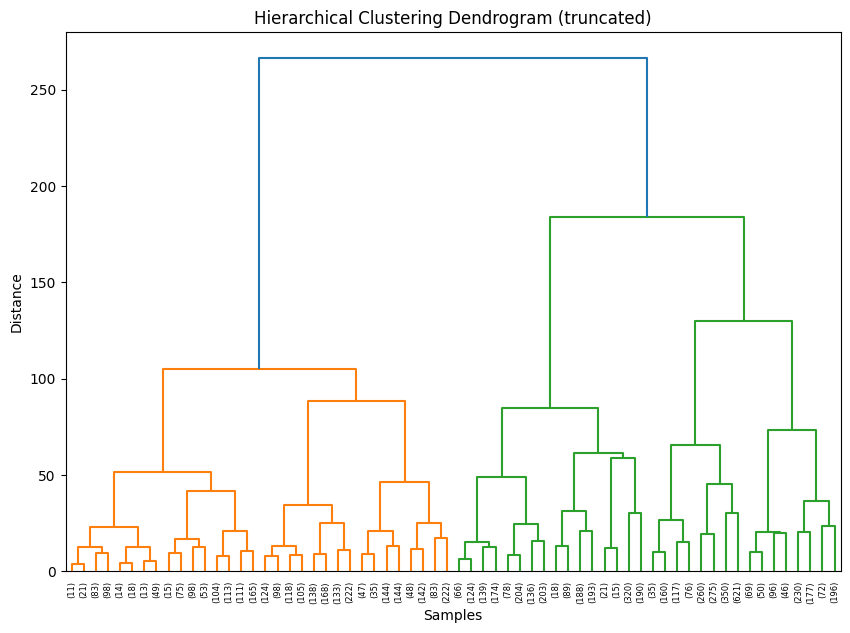

Hierarchical Clustering:
  Silhouette Score: 0.2629
  Davies-Bouldin Index: 1.0717



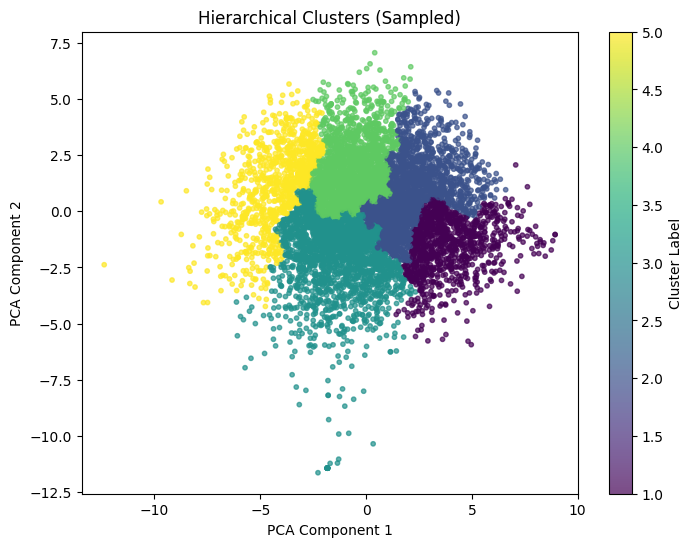

In [36]:
sample_size = 8000
idx = np.random.choice(len(X_pca), sample_size, replace=False)
X_pca_small = X_pca[idx]

linked = linkage(X_pca_small, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

k = 5
hier_labels = fcluster(linked, k, criterion='maxclust')

print(f'Hierarchical Clustering:')
print(f'  Silhouette Score: {silhouette_score(X_pca_small, hier_labels):.4f}')
print(f'  Davies-Bouldin Index: {davies_bouldin_score(X_pca_small, hier_labels):.4f}')
print()


plot_clusters(X_pca_small, hier_labels, 'Hierarchical Clusters (Sampled)')

For DBSCAN, I set the epsilon parameter to 0.5 and minimum samples to 5. The algorithm identified 2 clusters and 64 noise points. Despite fewer clusters, it achieved a higher Silhouette Score of 0.4817 but a higher Davies-Bouldin Index of 2.0357. The clusters and noise points were visualized on the PCA projection as well.

Number of clusters found by DBSCAN: 2
Number of noise points: 64
Silhouette Score (DBSCAN): 0.4817
Davies-Bouldin Index (DBSCAN): 2.0357


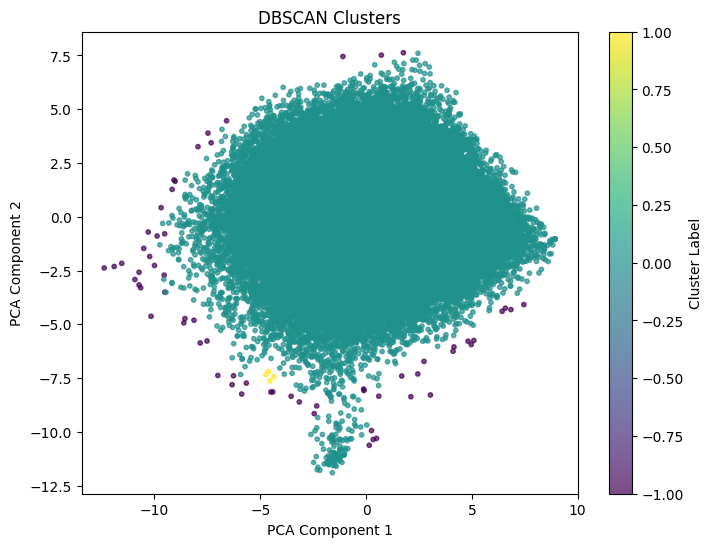

In [37]:
eps = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_pca)

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f'Number of clusters found by DBSCAN: {n_clusters}')
print(f'Number of noise points: {n_noise}')

if n_clusters > 1:
    print(f'Silhouette Score (DBSCAN): {silhouette_score(X_pca, dbscan_labels):.4f}')
    print(f'Davies-Bouldin Index (DBSCAN): {davies_bouldin_score(X_pca, dbscan_labels):.4f}')
else:
    print('Not enough clusters to compute Silhouette or Davies-Bouldin')

plot_clusters(X_pca, dbscan_labels, 'DBSCAN Clusters')

In [38]:
kmeans_silhouette = silhouette_score(X_pca, kmeans_labels)
kmeans_db = davies_bouldin_score(X_pca, kmeans_labels)

if len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0) > 1:
    dbscan_silhouette = silhouette_score(X_pca, dbscan_labels)
    dbscan_db = davies_bouldin_score(X_pca, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db = None

hier_silhouette = silhouette_score(X_pca_small, hier_labels)
hier_db = davies_bouldin_score(X_pca_small, hier_labels)

metrics_df = pd.DataFrame({
    'Algorithm': ['KMeans', 'DBSCAN', 'Hierarchical'],
    'Silhouette Score': [kmeans_silhouette, dbscan_silhouette, hier_silhouette],
    'Davies-Bouldin Index': [kmeans_db, dbscan_db, hier_db]
})

print(metrics_df.to_string(index=False))

   Algorithm  Silhouette Score  Davies-Bouldin Index
      KMeans          0.324831              0.914406
      DBSCAN          0.481658              2.035655
Hierarchical          0.262850              1.071676


### Results

I compared the three clustering algorithms based on the Silhouette Score and Davies-Bouldin Index. The results show that KMeans achieved the highest Silhouette Score of approximately 0.325, indicating better-defined clusters compared to Hierarchical Clustering and DBSCAN. Similarly, KMeans had the lowest Davies-Bouldin Index at about 0.91, reflecting more distinct and well-separated clusters. Overall, these metrics suggest that KMeans provided the most coherent clustering of personality profiles in this analysis.

C:\Users\Sara\AppData\Local\Temp\ipykernel_22304\2666487782.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=my_df, x='Algorithm', y='Silhouette Score', palette='Blues_d')


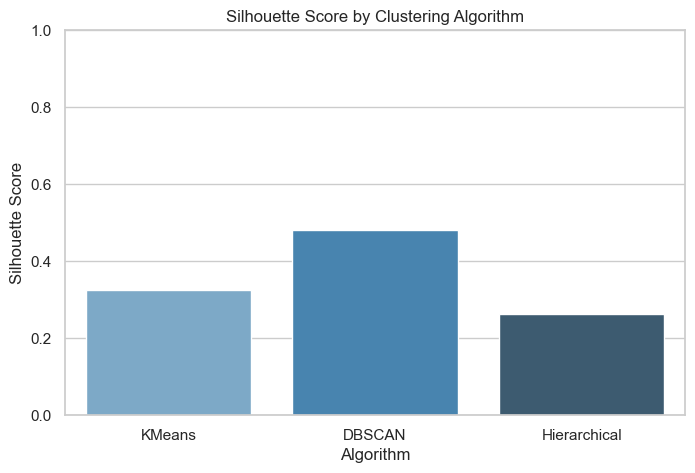

C:\Users\Sara\AppData\Local\Temp\ipykernel_22304\2666487782.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=my_df, x='Algorithm', y='Davies-Bouldin Index', palette='Reds_d')


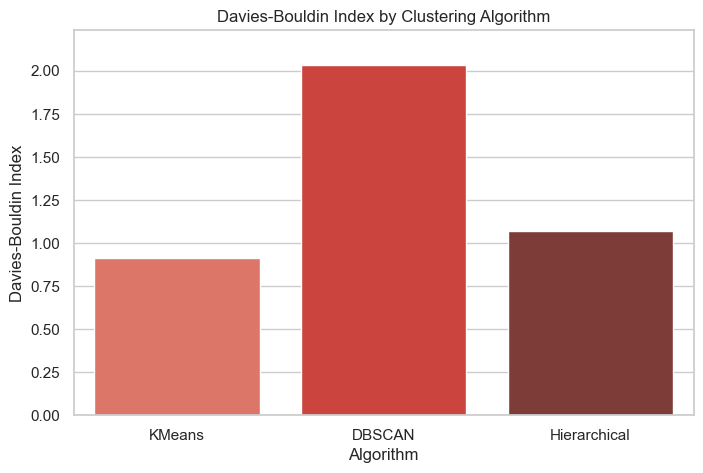

In [39]:
results = {
    'Algorithm': ['KMeans', 'DBSCAN', 'Hierarchical'],
    'Silhouette Score': [0.324831, 0.481658, 0.262850],
    'Davies-Bouldin Index': [0.914406, 2.035655, 1.071676]
}

my_df = pd.DataFrame(results)

sns.set(style='whitegrid')

plt.figure(figsize=(8, 5))
sns.barplot(data=my_df, x='Algorithm', y='Silhouette Score', palette='Blues_d')
plt.title('Silhouette Score by Clustering Algorithm')
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=my_df, x='Algorithm', y='Davies-Bouldin Index', palette='Reds_d')
plt.title('Davies-Bouldin Index by Clustering Algorithm')
plt.ylim(0, max(my_df['Davies-Bouldin Index']) + 0.2)
plt.show()

### Conclusion
In this assignment, I applied multiple unsupervised clustering algorithms to the Big Five Personality Test dataset to identify distinct personality profiles. After careful data cleaning, scaling, and dimensionality reduction, I evaluated K-Means, Hierarchical Clustering, and DBSCAN models using internal validation metrics and visualizations. The analysis showed that K-Means produced the most well-defined and separated clusters, making it the most effective method for this dataset. Sampling was necessary for hierarchical clustering due to computational constraints, but the results still provided valuable insights. Overall, this study demonstrates how clustering techniques can uncover meaningful patterns in personality data, offering a useful approach for psychological profiling and related applications.